# Background

This notebook is an interactive tool for evaluating scoring methods for frame design.

In [1]:
import frame_methods
import engine_methods as em
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Loading chipmunk for Windows (64bit) [c:\python\venvs\pyframe\lib\site-packages\pymunk\chipmunk64.dll]


We must first setup a sample environment with a frame and components.

In [2]:
### Setup frame environment
y_centerline = 200
left_buffer = 0

base_bom = frame_methods.read_bom(bom_name = "bom1.json")
part_shelf = base_bom.items
frame = frame_methods.frame_layout(bom_frame_spec = base_bom.frame_spec, frame_width = 35)

# Scoring

## Weight Distribution- X

Weight distribution in X (fore-aft) is scored using an exponential. Scoring curves are defined by two parameters: Shape and minimum theoretical collapsible length.

Alternatively, a logit curve is proposed as a CG_x scoring method.

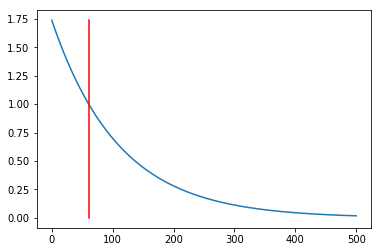

In [13]:
# Define shape variable

# Get theoretical max-forward CG_x:
min_length = em.get_min_collapsible_x(part_shelf, strategy = 'avg')
print("Min Length:", min_length)

# Plot scoring method
CG_x = np.arange(0, 500, 0.01)
CG_x_precalc = (CG_x - min_length) / (frame.frame_length - min_length)

@interact(CG_x_shape=(0.05, 1, 0.05))
def plt_CG_x(CG_x_shape = 0.3):
    CG_x_score = np.exp(-CG_x_precalc / CG_x_shape)

    plt.plot(CG_x, CG_x_score)
    plt.plot((min_length, min_length), (0, max(CG_x_score)), 'red')
    plt.show()

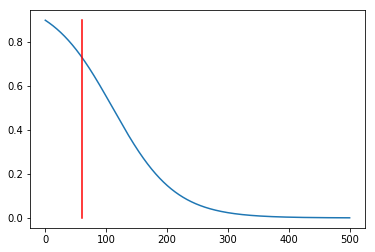

In [9]:
def plt_CG_x_logit(s, min_length):
    u = min_length + (frame.frame_length / 10)
    CG_x_logit = 1 - (1 / (1 + np.exp(-(CG_x- u)/s)))
    plt.plot(CG_x, CG_x_logit)
    plt.plot((min_length, min_length), (0, max(CG_x_logit)), 'red')
    plt.show()
interact(plt_CG_x_logit, s = (1, 500, 1))

## Weight Distribution- Y

Y weight distribution is scored symmetrically about the y centerline. The curve is a normal distribution, with a shape define by 1) the frame width and 2) a shape factor.

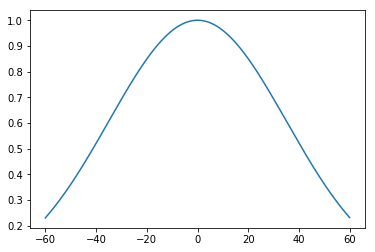

In [16]:
@interact(CG_y_shape = (0.05, 1, 0.05))

def plt_CG_Y(CG_y_shape = 1.0):
    rv = norm(loc = 0.0, scale = frame.frame_width * CG_y_shape)
    x = np.arange(-60, 60, .1)
    CG_y_score = rv.pdf(x) / max(rv.pdf(x))
    #plot the pdfs of these normal distributions 
    plt.plot(x, CG_y_score)
    plt.show()

## Collisions

In [ ]:
Collisions are scored on an exponential curve, dictated by a shape parameter

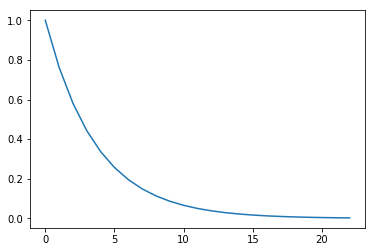

In [20]:
@interact(collision_shape = (0.01, 1, 0.01))

def plt_col(collision_shape = 0.15):
    collisions = np.arange(0, len(part_shelf), 1)
    collision_score = np.exp(-(collisions/len(part_shelf))/collision_shape)
    plt.plot(collisions, collision_score)
    plt.show()

## Time

Score decays slowly over time in a linear manner with every frame

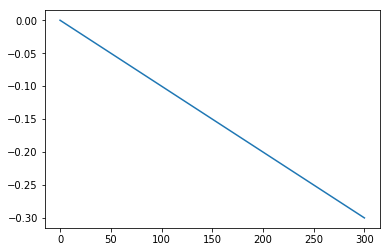

In [18]:
seconds = np.arange(0, 300, 1/30)

time_penalty = seconds * -0.001

plt.plot(seconds, time_penalty)
plt.show()

# Combined Scores

With all individual scores generally ranging between 0-1, we apply weights to combine scores into a total score.